# Датасет Кати

In [36]:
%matplotlib notebook
from __future__ import division, print_function, unicode_literals

import sys
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import IPython as IPy
import sklearn as skl
from sklearn.model_selection import train_test_split

import os
import tarfile
import urllib
import pickle

import joblib

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from clintraj_qi import *
from clintraj_optiscale import *
from clintraj_eltree import *
from clintraj_util import *
import scipy.stats

In [49]:
def save_obj(obj, name):
    os.makedirs("obj", exist_ok=True)
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
dataset = pd.read_csv('datasets/meta.csv', sep=',',index_col=[0])
dataset

,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate
0,0.076632,NaN,0.279263,0.123100,NaN,171.184023
1,0.107158,NaN,0.298000,0.112200,NaN,187.826087
2,0.082800,NaN,0.284947,0.108200,NaN,186.244078
3,0.081500,NaN,0.314706,0.142556,NaN,185.546875
4,0.075053,NaN,0.268421,0.084762,NaN,170.239596
...,...,...,...,...,...,...
23995,0.104125,0.0,0.376000,0.153500,0.071875,75.942958
23996,0.100500,0.0,0.413750,0.193625,0.080750,75.598488
23997,0.094750,0.0,0.420625,0.190500,0.087500,75.062552
23998,0.091500,0.0,0.416125,0.178625,0.093750,74.775673


In [4]:
for col in dataset:
    print(f'{col}: {dataset[col].isna().sum()} NaN vals')

Qrst_dur: 8 NaN vals
P_Q_duration: 3103 NaN vals
Q_T_duration: 14 NaN vals
T_duration: 13 NaN vals
P_duration: 3082 NaN vals
Heart_rate: 10 NaN vals


In [5]:
quantify_nans(dataset)

Missing values 6230 (5.191666666666666%)
Number of complete rows: 19333 (80.55416666666666%)


In [6]:
X_data_raw = dataset

## План

Построим кучу деревьев на основе:
1. Масштабирования: нормализации, стандартизации, оптимизации (если это так можно назвать),
2. 2D/3D.

## 1. Обработка датасета

### Нормализация и стандартизация

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('mm_scaler', MinMaxScaler()),
                        ])

num_pipeline_std = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('mm_scaler', StandardScaler()),
                        ])

X_data_prep = num_pipeline.fit_transform(X_data_raw) 
X_data_prep_std = num_pipeline_std.fit_transform(X_data_raw) 
X_prep = pd.DataFrame(X_data_prep)
X_prep_std = pd.DataFrame(X_data_prep_std)

### Оптимизация

In [8]:
variable_types, binary, continuous, ordinal = detect_variable_type(dataset, 10, verbose=False)
dfq,replacement_info = quantify_dataframe_univariate(dataset, variable_types)
with open('temp.txt','w') as fid:
    fid.write(replacement_info)

Matrix shape: (19333, 5)
Effective linear dimension 5


<IPython.core.display.Javascript object>


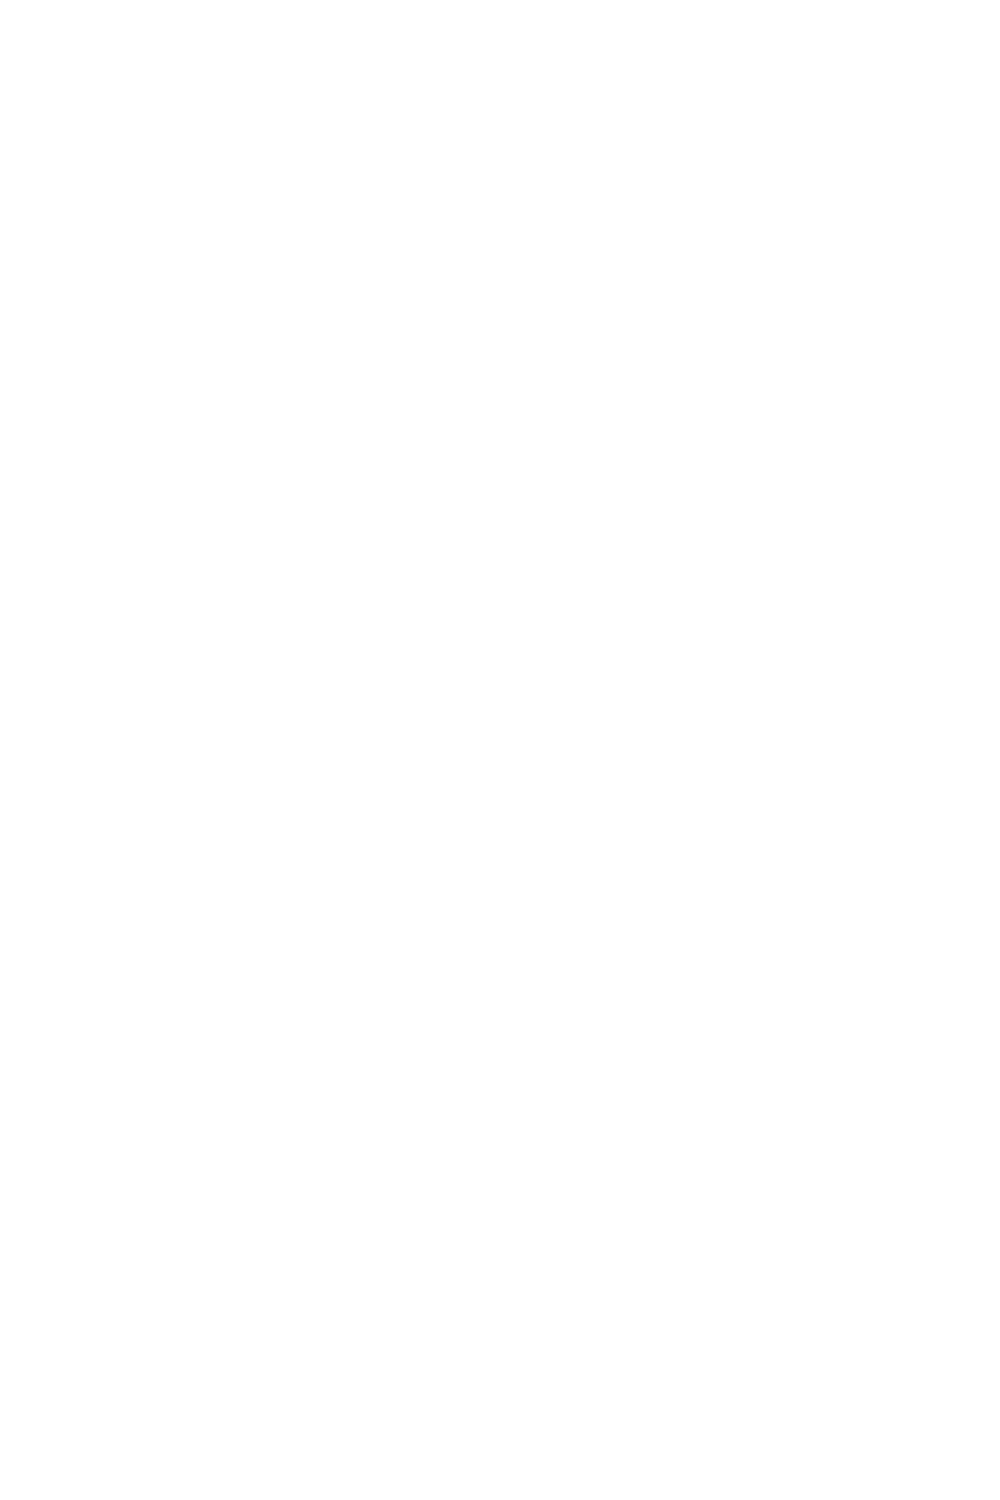

Full matrix shape (24000, 5)


,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate
0,0.076632,0.15143,0.279263,0.123100,0.083812,171.184023
1,0.107158,0.15143,0.298000,0.112200,0.083812,187.826087
2,0.082800,0.15143,0.284947,0.108200,0.083812,186.244078
3,0.081500,0.15143,0.314706,0.142556,0.083812,185.546875
4,0.075053,0.15143,0.268421,0.084762,0.083812,170.239596
...,...,...,...,...,...,...
23995,0.104125,0.00000,0.376000,0.153500,0.071875,75.942958
23996,0.100500,0.00000,0.413750,0.193625,0.080750,75.598488
23997,0.094750,0.00000,0.420625,0.190500,0.087500,75.062552
23998,0.091500,0.00000,0.416125,0.178625,0.093750,74.775673


In [9]:
dfq_imputed = SVDcomplete_imputation_method(dfq, variable_types, verbose=True,num_components=-1)
dequant_info = invert_quant_info(load_quantification_info('temp.txt'))
df_imputed = dequantify_table(dfq_imputed,dequant_info)
display(df_imputed)

Removing  0 columns

 Initial Q2: 1.4408038870811701
Initial quantification table:
[]
Monotonicity: (True, 10000)
Iteration 0 Q2= 1.4408038870811701


<IPython.core.display.Javascript object>


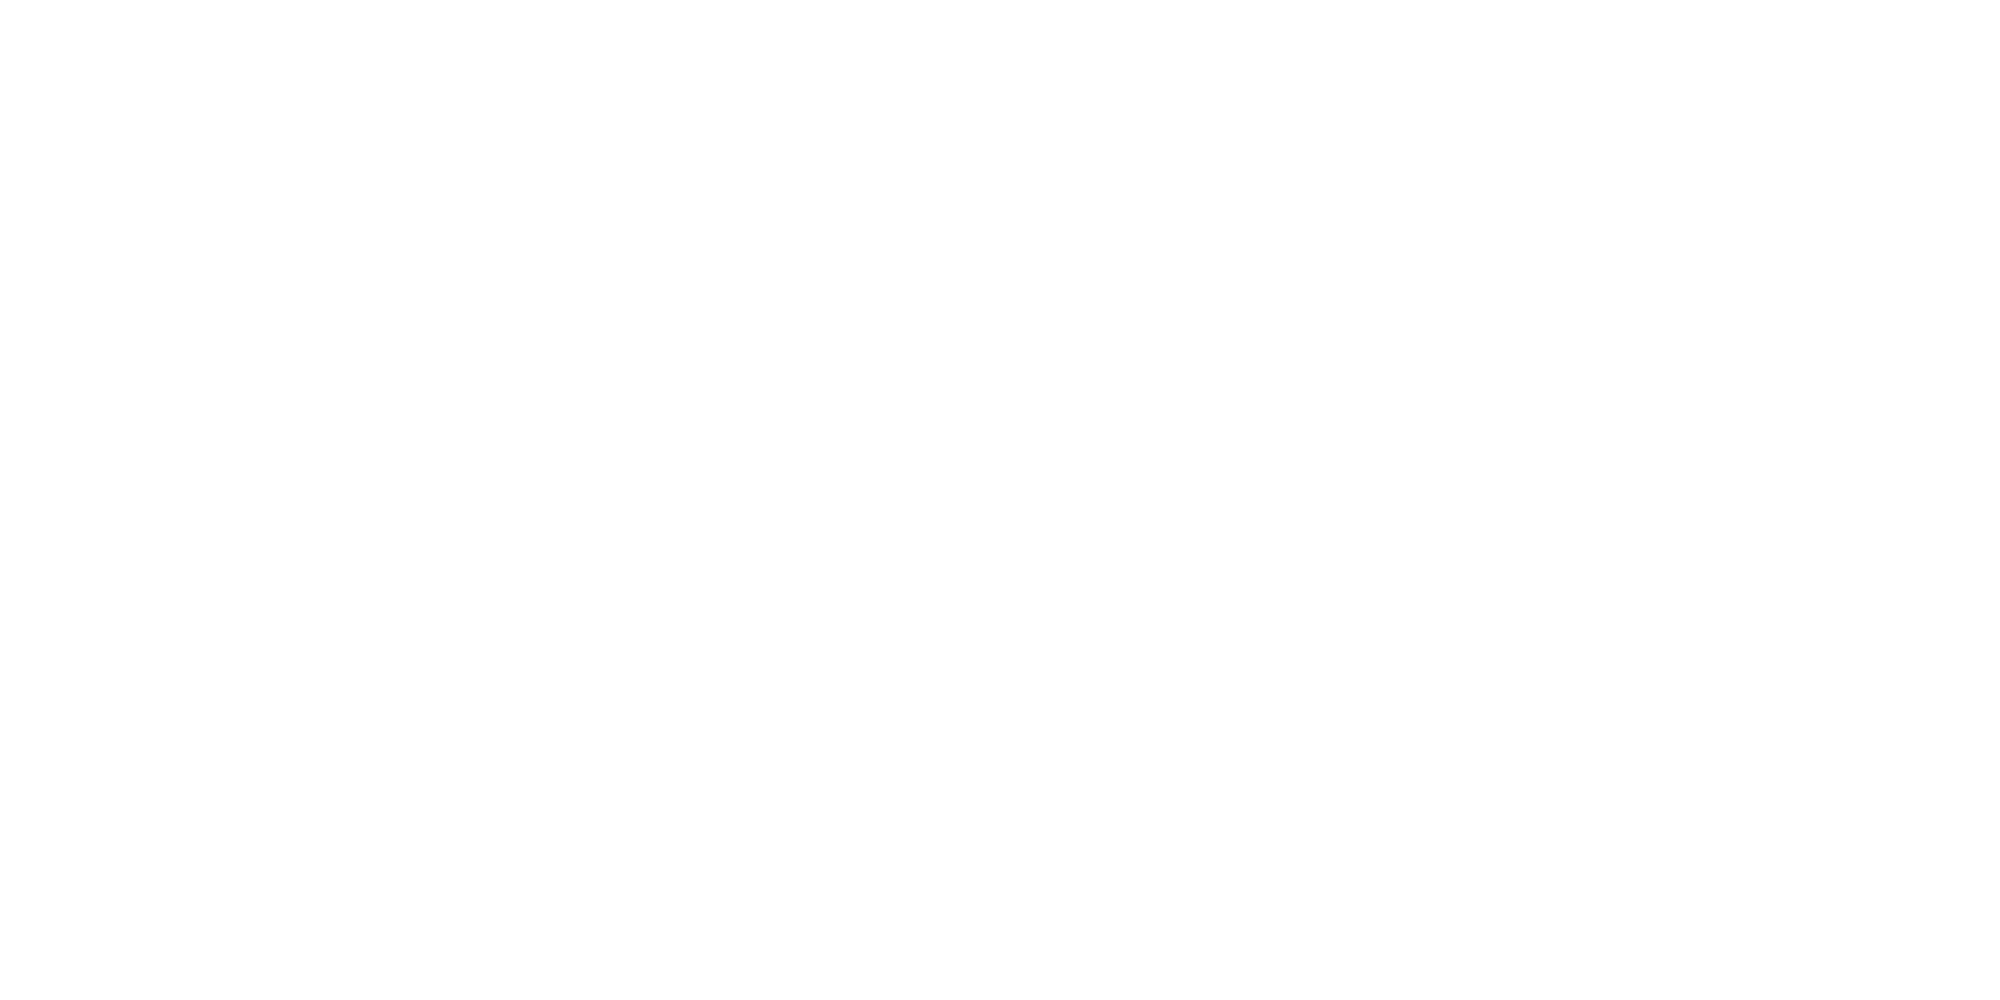


 Q2 after update: 1.4408038870811852
Final quantification table:
[]
Monotonicity: (True, 10000)


In [10]:
df = remove_constant_columns_from_dataframe(df_imputed)
variable_names = [str(s) for s in df.columns[1:]]
X = df[df.columns[1:]].to_numpy()
X_orig_opt = X
X_before_scaling = X.copy()
X_opt, cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.6)

In [11]:
import elpigraph
from elpigraph import computeElasticPrincipalTree

nnodes = 50
X_norm = X_prep.to_numpy()
X_std = X_prep_std.to_numpy()

In [12]:
def do_PCA(X):
    # reduced_dimension = 12
    X_to_PCA = scipy.stats.zscore(X)
    pca = PCA(n_components=X_to_PCA.shape[1],svd_solver='full')
    Y = pca.fit_transform(X_to_PCA)
    v = pca.components_.T
    mean_val = np.mean(X_to_PCA,axis=0)
    return Y[:], v, mean_val # ,0:reduced_dimension]

X_pca_norm, components_norm, mnval_norm = do_PCA(X_norm)
X_pca_std, components_std, mnval_std = do_PCA(X_std)
X_pca_opt, components_opt, mnval_opt = do_PCA(X_opt)

In [46]:
def create_extended_tree(X, nnodes):
    tree_elpi = computeElasticPrincipalTree(X, nnodes, alpha=0.01, Mu=0.1, Lambda=0.05, FinalEnergy='Penalized')[0]
    prune_the_tree(tree_elpi)
    tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)
    return tree_extended
'''
tree_norm = create_extended_tree(X_pca_norm, 50)
tree_std = create_extended_tree(X_pca_std, 50)
tree_opt = create_extended_tree(X_pca_opt, 50)
'''

'\ntree_norm = create_extended_tree(X_pca_norm, 50)\ntree_std = create_extended_tree(X_pca_std, 50)\ntree_opt = create_extended_tree(X_pca_opt, 50)\n'

In [48]:
tree_norm = load_obj("tree_norm")
tree_std = load_obj("tree_std")
tree_opt = load_obj("tree_opt")

In [44]:
X_orig_imputer = SimpleImputer(strategy="median").fit_transform(dataset)

In [15]:
def tree_visualization(tree_elpi, X, X_orig, components_vec, mean_val):
    vec_labels_by_branches = partition_data_by_tree_branches(X, tree_elpi)

    partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = tree_elpi['NodePositions'], 
                                                        SquaredX = np.sum(X**2,axis=1,keepdims=1),
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf
                                                        )
    partition_by_node = np.zeros(len(partition))
    for i,p in enumerate(partition):
        partition_by_node[i] = p[0]

    variable_names = [str(s) for s in dataset.columns[1:]]
    visualize_eltree_with_data(tree_elpi, X, X_orig, components_vec, mean_val, 'k', variable_names,
                              Color_by_partitioning = True, visualize_partition = vec_labels_by_branches)

<IPython.core.display.Javascript object>


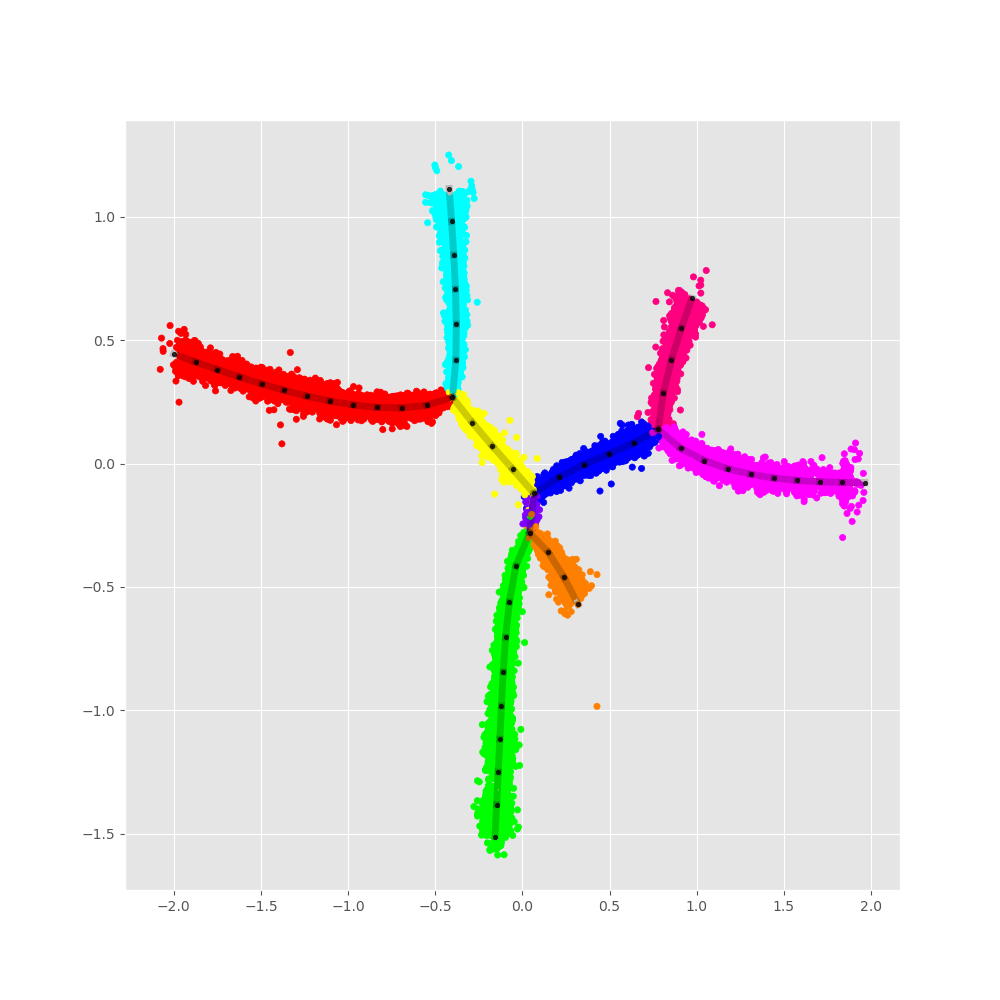

In [21]:
fig = plt.figure(figsize=(10, 10))
tree_visualization(tree_norm, X_pca_norm, X_orig_imputer, components_norm, mnval_norm)
plt.show()

<IPython.core.display.Javascript object>


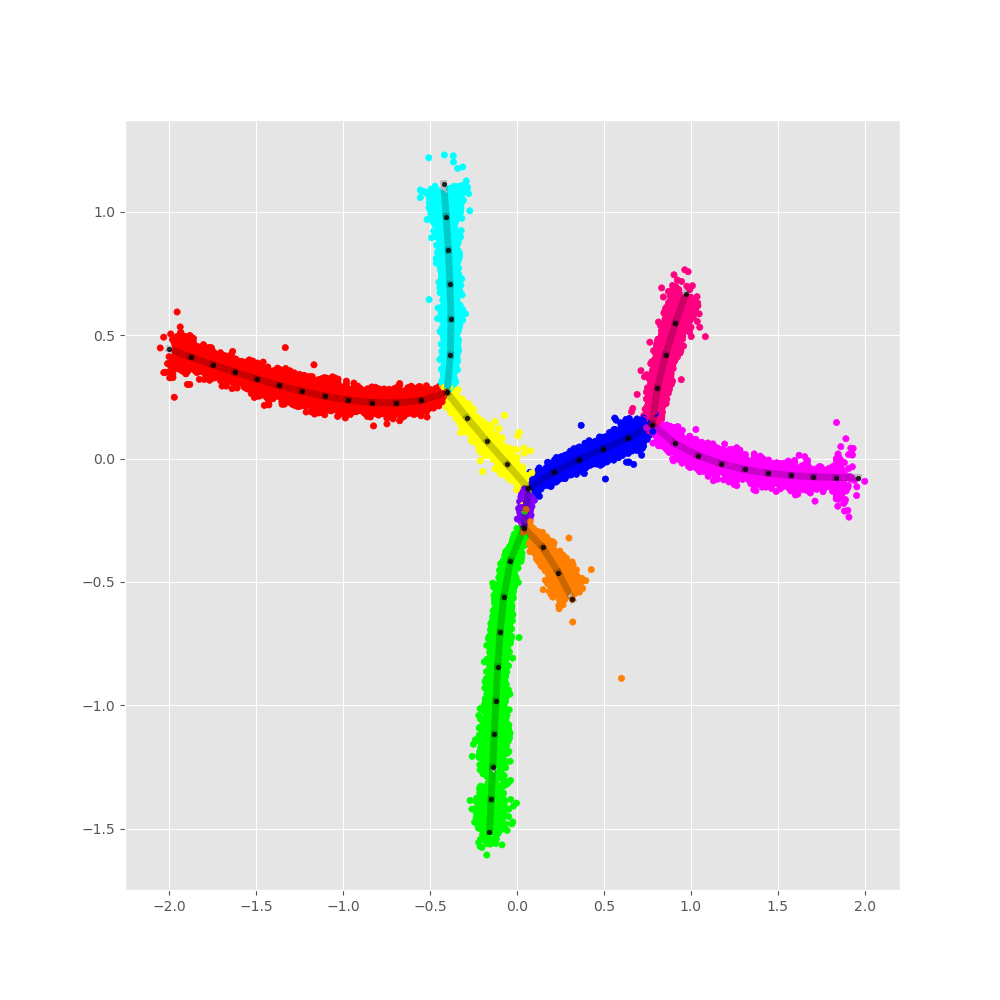

In [22]:
fig = plt.figure(figsize=(10, 10))
tree_visualization(tree_std, X_pca_std, X_orig_imputer, components_std, mnval_std)
plt.show()

<IPython.core.display.Javascript object>


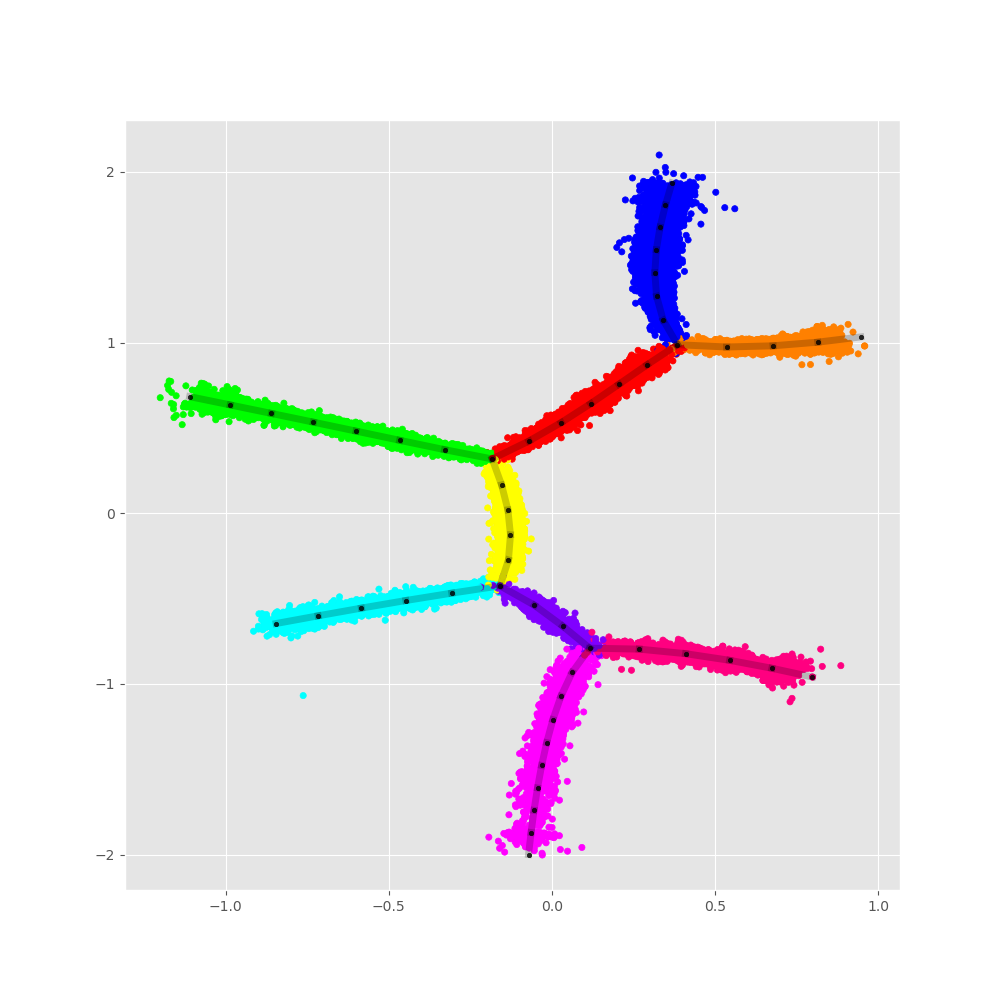

In [23]:
fig = plt.figure(figsize=(10, 10))
tree_visualization(tree_opt, X_pca_opt, X_orig_opt, components_opt, mnval_opt)
plt.show()

In [29]:
type(tree_norm)

dict